In [610]:
import tensorflow as tf
import tensorflow.contrib.learn as learn
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle

In [3]:
df = pd.read_csv('../data/train_clean.csv')

In [4]:
X=df[['bedrooms_total',
 'baths_total',
 'acres',
 'sq_ft_tot_fn',
 'tax_gross_amount',
 'assessment_value_town',
 'garage_capacity',
 'year_built',
 'total_stories',
 'rooms_total',
 'garage',
 'flood_zone',
 'basement',
 'city__Pomfret',
 'city__Woodstock',
 'covenants__Unknown',
 'covenants__Yes',
 'garage_type',
 'short_sale',
 'basement_access_type',
 'current_use']]
y = df['price_closed']

In [5]:
test = pd.read_csv('../data/test_clean.csv')

In [7]:
X_Test = test[['bedrooms_total',
 'baths_total',
 'acres',
 'sq_ft_tot_fn',
 'tax_gross_amount',
 'assessment_value_town',
 'garage_capacity',
 'year_built',
 'total_stories',
 'rooms_total',
 'garage',
 'flood_zone',
 'basement',
 'city__Pomfret',
 'city__Woodstock',
 'covenants__Unknown',
 'covenants__Yes',
 'garage_type',
 'short_sale',
 'basement_access_type',
 'current_use']]

In [6]:
validate = pd.read_csv('../data/validate_clean.csv')['price_closed']

# XGBoost

In [8]:
df_train_xgb = xgb.DMatrix(X, y)

In [160]:
params = {"objective": "reg:linear", "booster":"gblinear", "alpha": 0.01, "lambda":0.0001, "eval_metric":"rmse"}
gbm = xgb.train(dtrain=df_train_xgb,params=params)

In [162]:
prediction = gbm.predict(xgb.DMatrix(X_Test))

In [163]:
print('Mean Absolute Error: {}'.format(mean_absolute_error(validate, prediction)))
print('Mean Squared Error: {}'.format(mean_squared_error(validate, prediction)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(validate, prediction))))

Mean Absolute Error: 200872.48369565216
Mean Squared Error: 131823481859.79988
Root Mean Squared Error: 363075.0361286216


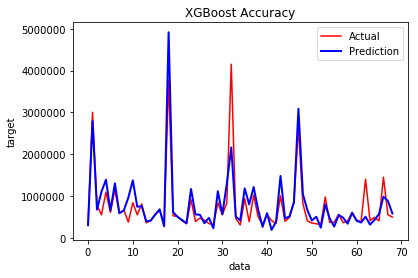

In [165]:
plt.plot(validate, color='red', label='Actual')
plt.plot(prediction, color='blue', lw=2, label='Prediction')
plt.xlabel('data')
plt.ylabel('target')
plt.title('XGBoost Accuracy')
plt.legend()
plt.show()

In [167]:
xgbg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgbg.fit(X,y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.75)

In [170]:
prediction = xgbg.predict(X_Test)

In [171]:
print('Mean Absolute Error: {}'.format(mean_absolute_error(validate, prediction)))
print('Mean Squared Error: {}'.format(mean_squared_error(validate, prediction)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(validate, prediction))))

Mean Absolute Error: 191089.45788043478
Mean Squared Error: 157445322695.69095
Root Mean Squared Error: 396793.8037516349


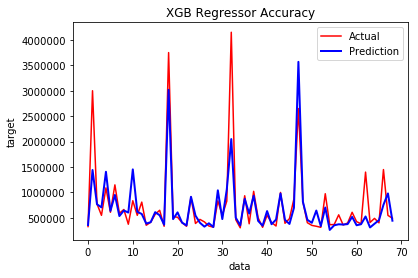

In [172]:
plt.plot(validate, color='red', label='Actual')
plt.plot(prediction, color='blue', lw=2, label='Prediction')
plt.xlabel('data')
plt.ylabel('target')
plt.title('XGB Regressor Accuracy')
plt.legend()
plt.show()

So XGBoost did better on extreme ranges while XGB Regressor did better on mid-range

In [612]:
filename = 'gbm_model.sav'
pickle.dump(gbm, open(filename, 'wb'))

# Tensor Flow

In [333]:
X_orig=df[['bedrooms_total',
 'baths_total',
 'acres',
 'sq_ft_tot_fn',
 'tax_gross_amount',
 'assessment_value_town',
 'garage_capacity',
 'year_built',
 'total_stories',
 'rooms_total',
 'garage',
 'flood_zone',
 'basement',
 'city__Pomfret',
 'city__Woodstock',
 'covenants__Unknown',
 'covenants__Yes',
 'garage_type',
 'short_sale',
 'basement_access_type',
 'current_use']]
train_y = df['price_closed'].values.astype('float32').reshape(137,1)

In [321]:
scaler= StandardScaler()
scaled_X = scaler.fit_transform(X_orig).astype('float32')

In [465]:
# Parameters
learning_rate = 0.001
training_epochs = 1000
display_step = 50

In [466]:
# tf Graph Input
X = tf.placeholder("float")
Y = tf.placeholder("float")

# Set model weights
W = tf.Variable(float(1), name="weight")
b = tf.Variable(np.random.randn(), name="bias")

In [467]:
# Construct a linear model
pred = tf.add(tf.multiply(X, W), b)

In [486]:
# Mean squared error
cost = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*len(scaled_X))
# Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [487]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [488]:
cost_history = []

In [491]:
with tf.Session() as sess:
    sess.run(init)

    # Fit all training data
    for epoch in range(training_epochs):

        for (x, y) in zip(scaled_X, train_y):
            sess.run(optimizer, feed_dict={X: x, Y: y})

        #Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c = sess.run(cost, feed_dict={X: scaled_X, Y:train_y})
            cost_history.append(c)
            print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.1f}".format(c), \
                "W=", sess.run(W), "b=", sess.run(b))

    print ("Optimization Finished!")
    training_cost = sess.run(cost, feed_dict={X: scaled_X, Y: train_y})
    print ("Training cost=", training_cost, "W=", sess.run(W), "b=", sess.run(b), '\n')
    pred_y = sess.run(pred,feed_dict={X: scaled_X})
    mse = tf.reduce_mean(tf.square(pred_y - train_y))
    print("RMSE: %.4f" % np.sqrt(sess.run(mse)))

Epoch: 0050 cost= 5080815763456.0 W= 107630.0 b= 478812.0
Epoch: 0100 cost= 4439255023616.0 W= 145285.0 b= 646350.0
Epoch: 0150 cost= 4361008709632.0 W= 158458.0 b= 704972.0
Epoch: 0200 cost= 4351537184768.0 W= 163066.0 b= 725483.0
Epoch: 0250 cost= 4350415470592.0 W= 164679.0 b= 732662.0
Epoch: 0300 cost= 4350289903616.0 W= 165243.0 b= 735174.0
Epoch: 0350 cost= 4350280204288.0 W= 165440.0 b= 736053.0
Epoch: 0400 cost= 4350279680000.0 W= 165508.0 b= 736355.0
Epoch: 0450 cost= 4350279680000.0 W= 165533.0 b= 736477.0
Epoch: 0500 cost= 4350279680000.0 W= 165543.0 b= 736520.0
Epoch: 0550 cost= 4350281777152.0 W= 165546.0 b= 736527.0
Epoch: 0600 cost= 4350282039296.0 W= 165547.0 b= 736527.0
Epoch: 0650 cost= 4350282039296.0 W= 165547.0 b= 736527.0
Epoch: 0700 cost= 4350282039296.0 W= 165547.0 b= 736527.0
Epoch: 0750 cost= 4350282039296.0 W= 165547.0 b= 736527.0
Epoch: 0800 cost= 4350282039296.0 W= 165547.0 b= 736527.0
Epoch: 0850 cost= 4350282039296.0 W= 165547.0 b= 736527.0
Epoch: 0900 co

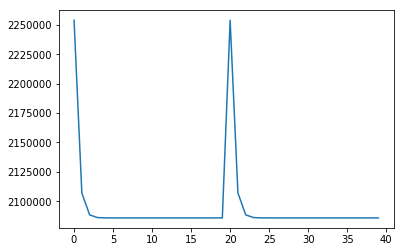

In [492]:
plt.plot(np.sqrt(cost_history))
plt.show()

## Contrib Learn

In [498]:
X=df[['bedrooms_total',
 'baths_total',
 'acres',
 'sq_ft_tot_fn',
 'tax_gross_amount',
 'assessment_value_town',
 'garage_capacity',
 'year_built',
 'total_stories',
 'rooms_total',
 'garage',
 'flood_zone',
 'basement',
 'city__Pomfret',
 'city__Woodstock',
 'covenants__Unknown',
 'covenants__Yes',
 'garage_type',
 'short_sale',
 'basement_access_type',
 'current_use']]
y = df['price_closed']
scaler= StandardScaler()
scaled_X = scaler.fit_transform(X)

In [501]:
X = scaled_X.astype(np.float32)
y = y.astype(np.float32)

In [575]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [576]:
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)

In [606]:
regressor = learn.DNNRegressor(hidden_units=[10, 20, 10],feature_columns=feature_columns,model_dir="/tmp/contrib",optimizer=tf.train.GradientDescentOptimizer(0.01))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12d7fa240>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/contrib'}


In [607]:
regressor.fit(X_train,y_train,steps=200,batch_size=20)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


/anaconda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:260: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/contrib/model.ckpt-3802
INFO:tensorflow:Saving checkpoints for 3803 into /tmp/contrib/model.ckpt.
INFO:tensorflow:loss = 5.51097e+11, step = 3803
INFO:tensorflow:global_step/sec: 553.349
INFO:tensorflow:loss = 1.08089e+11, step = 3903 (0.182 sec)
INFO:tensorflow:Saving checkpoints for 4002 into /tmp/contrib/model.ckpt.
INFO:tensorflow:Loss for final step: 5.656e+11.


DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x127dd5c88>, 'hidden_units': [10, 20, 10], 'feature_columns': (_RealValuedColumn(column_name='', dimension=21, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': <tensorflow.python.training.gradient_descent.GradientDescentOptimizer object at 0x127dd5c50>, 'activation_fn': <function relu at 0x111834a60>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [608]:
prediction = list(regressor.predict(X_test, as_iterable=True))

Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


/anaconda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:260: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Restoring parameters from /tmp/contrib/model.ckpt-4002


In [609]:
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, prediction)))
print('Mean Squared Error: {}'.format(mean_squared_error(y_test, prediction)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(y_test, prediction))))

Mean Absolute Error: 388367.75
Mean Squared Error: 343354441728.0
Root Mean Squared Error: 585964.5625
